# View Extracted Pixel Exposure Sky background and noise  from Calexp and CalexpBackground and CCD Visits for Auxtel

- Just read pandas dataframe and show plots

- author Sylvie Dagoret-Campagne
- creation date 2024-05-17
- last update 2024-05-17
- affiliation : IJCLab
- kernel : **w_2024_16**

``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time

In [3]:
import matplotlib.dates as mdates
#month_locator = mdates.MonthLocator(interval=1)
#day_locator = mdates.DayLocator(interval=1)
#year_month_formatter = mdates.DateFormatter("%Y-%m") 

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")





In [4]:
from lsst.daf.butler import Butler



# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collections = [collection]
collectionn = collection
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_photocalib = f"ccdVisittractpatch_{collectionStr}_calexpinfo.csv"
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"

suptitle = collectionStr + f" inst = {instrument} "

In [5]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4


## Read inputs

### Access CCD visit table

In [6]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069']


In [7]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [8]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [9]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43729938688    20240410
43729938944    20240410
43729939200    20240410
43729939456    20240410
43729939712    20240410
Name: nightObs, Length: 5397, dtype: int64

In [10]:
# get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [11]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [12]:
# select the missing quantities (the time)
ccd_visit_table_subset = ccd_visit_table[["Time","obsStart"]]

### Read pandas dataframe containing the tract-patch decomposition of visits

In [13]:

# need the visit file because observation date is missing
file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
df1 = pd.read_csv(file_selected_visits,index_col=0)

### Read the dataframe with the extracted parameters from calexp,calexpBackground

In [14]:
df = pd.read_csv(fn_ccdVisit_photocalib,index_col=0)

In [15]:
df

,idx,visitId,ccdVisitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
0,0,2023051100262,40919696896,r,0,27.691925,1.823818,11.193549,7.856800,30.0,...,0.248366,0.225585,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486
1,1,2023051100264,40919697408,i,0,27.854723,1.762794,28.073927,8.586373,30.0,...,0.179049,0.156368,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220
2,2,2023051100268,40919698432,r,0,27.773005,1.721301,10.700970,7.854424,30.0,...,0.209981,0.178780,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189
3,3,2023051100270,40919698944,i,0,27.859426,1.695170,23.952974,8.440454,30.0,...,0.153219,0.113119,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426
4,4,2023051100271,40919699200,i,0,27.846539,1.677014,23.321407,8.416399,30.0,...,0.192677,0.186060,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,5392,2024041000489,43729938688,y,0,26.041475,1.511427,15.985236,8.106778,30.0,...,0.300461,0.257039,17.008020,16.292530,38.432150,8.241574,16.110833,16.098310,8.194294,8.173982
5393,5393,2024041000490,43729938944,g,0,27.940567,1.520921,3.106054,7.474746,30.0,...,0.206186,0.178378,4.521265,3.421193,53.836727,7.590711,3.247030,3.252452,7.554529,7.511768
5394,5394,2024041000491,43729939200,r,0,27.792534,1.525628,6.620466,7.680325,30.0,...,0.397544,0.270320,8.553000,7.022195,79.708600,7.808471,6.775610,6.773452,7.748752,7.694970
5395,5395,2024041000492,43729939456,z,0,27.290150,1.530404,18.576742,8.271068,30.0,...,0.426516,0.321347,20.611366,19.032433,89.627600,8.429878,18.757024,18.734940,8.316185,8.294496


In [16]:
df.set_index("ccdVisitId",inplace=True)

In [17]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,0,2023051100262,r,0,27.691925,1.823818,11.193549,7.856800,30.0,30.490464,...,0.248366,0.225585,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486
40919697408,1,2023051100264,i,0,27.854723,1.762794,28.073927,8.586373,30.0,25.507239,...,0.179049,0.156368,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220
40919698432,2,2023051100268,r,0,27.773005,1.721301,10.700970,7.854424,30.0,27.956394,...,0.209981,0.178780,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189
40919698944,3,2023051100270,i,0,27.859426,1.695170,23.952974,8.440454,30.0,26.273077,...,0.153219,0.113119,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426
40919699200,4,2023051100271,i,0,27.846539,1.677014,23.321407,8.416399,30.0,26.568090,...,0.192677,0.186060,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43729938688,5392,2024041000489,y,0,26.041475,1.511427,15.985236,8.106778,30.0,125.915622,...,0.300461,0.257039,17.008020,16.292530,38.432150,8.241574,16.110833,16.098310,8.194294,8.173982
43729938944,5393,2024041000490,g,0,27.940567,1.520921,3.106054,7.474746,30.0,23.458452,...,0.206186,0.178378,4.521265,3.421193,53.836727,7.590711,3.247030,3.252452,7.554529,7.511768
43729939200,5394,2024041000491,r,0,27.792534,1.525628,6.620466,7.680325,30.0,27.368571,...,0.397544,0.270320,8.553000,7.022195,79.708600,7.808471,6.775610,6.773452,7.748752,7.694970


## Add to the main dataframe df, the obstime found in ccd_visit_table

In [18]:
df = df.join(ccd_visit_table_subset)

In [19]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m,Time,obsStart
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,0,2023051100262,r,0,27.691925,1.823818,11.193549,7.856800,30.0,30.490464,...,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486,2023-05-12 01:08:41.302993,2023-05-12 01:08:41.302993
40919697408,1,2023051100264,i,0,27.854723,1.762794,28.073927,8.586373,30.0,25.507239,...,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220,2023-05-12 01:14:49.912000,2023-05-12 01:14:49.912000
40919698432,2,2023051100268,r,0,27.773005,1.721301,10.700970,7.854424,30.0,27.956394,...,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189,2023-05-12 01:19:24.311494,2023-05-12 01:19:24.311494
40919698944,3,2023051100270,i,0,27.859426,1.695170,23.952974,8.440454,30.0,26.273077,...,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426,2023-05-12 01:22:21.150002,2023-05-12 01:22:21.150002
40919699200,4,2023051100271,i,0,27.846539,1.677014,23.321407,8.416399,30.0,26.568090,...,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023,2023-05-12 01:24:32.058502,2023-05-12 01:24:32.058502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43729938688,5392,2024041000489,y,0,26.041475,1.511427,15.985236,8.106778,30.0,125.915622,...,17.008020,16.292530,38.432150,8.241574,16.110833,16.098310,8.194294,8.173982,2024-04-11 03:28:33.433496,2024-04-11 03:28:33.433496
43729938944,5393,2024041000490,g,0,27.940567,1.520921,3.106054,7.474746,30.0,23.458452,...,4.521265,3.421193,53.836727,7.590711,3.247030,3.252452,7.554529,7.511768,2024-04-11 03:30:12.763000,2024-04-11 03:30:12.763000
43729939200,5394,2024041000491,r,0,27.792534,1.525628,6.620466,7.680325,30.0,27.368571,...,8.553000,7.022195,79.708600,7.808471,6.775610,6.773452,7.748752,7.694970,2024-04-11 03:30:59.394501,2024-04-11 03:30:59.394501


## Formula to bear in mind

$$
\left\{
\begin{array}{ccc} \\
m_{AB}  & = & -2.5\cdot \log_{10}(ADU) + m(ZP) \\ \\
F(Jy) & = & F_{AB}^{ref}(Jy) \cdot 10^{-0.4\cdot m(ZP)}\cdot ADU
\end{array}
\right.
$$

## Additionnal processing

$$
ZP(CCDvisit) = ZP(magzero_calexp) + 2.5\log_{10} \Delta t 
$$

- this shows that $ZP(CCDvisit)$ is relative to ADU while $ZP(magzero\_calexp)$ is relative to $ADU/\Delta t$.

In [20]:
df["magzero_dt"] = df["magzero"].apply(lambda x : x+2.5*np.log10(30))
df["zeroPoint_diff"] = df["zeroPoint"]-df["magzero_dt"]

### Add Sigma/N

In [21]:
df["sigmatoskybkg"] = df["sigMad_ce"]/df["med_bkg"]
df["sigmatoskybkg_max"] = df["med_bkg"].apply(lambda x : 1/np.sqrt(x))

In [22]:
df.columns

Index(['idx', 'visitId', 'band', 'detector', 'zeroPoint', 'airmass', 'skyBg',
       'skyNoise', 'expTime', 'photocalib_m', 'photocalib_e', 'magzero',
       'magzero_rms', 'magzero_nobj', 'bgmean', 'bgvar', 'mu_ce', 'med_ce',
       'std_ce', 'sigMad_ce', 'mu_ce_m', 'med_ce_m', 'std_ce_m', 'sigMad_ce_m',
       'mu_bkg', 'med_bkg', 'std_bkg', 'sigMad_bkg', 'mu_bkg_m', 'med_bkg_m',
       'std_bkg_m', 'sigMad_bkg_m', 'mu_pisr', 'med_pisr', 'std_pisr',
       'sigMad_pisr', 'mu_pisr_m', 'med_pisr_m', 'std_pisr_m', 'sigMad_pisr_m',
       'Time', 'obsStart', 'magzero_dt', 'zeroPoint_diff', 'sigmatoskybkg',
       'sigmatoskybkg_max'],
      dtype='object')

In [23]:
df["photocalib_mag"] = df["photocalib_m"].apply(convert_fluxtomag)

In [24]:
df["zeroPoint_photocalib_diff"] = df["zeroPoint"] - df["photocalib_mag"]
df["magzerodt_photocalib_diff"] = df["magzero_dt"] - df["photocalib_mag"]

## Split the dataframe in bands

In [25]:
df_g = df[df["band"] == 'g']
df_r = df[df["band"] == 'r']
df_i = df[df["band"] == 'i']
df_z = df[df["band"] == 'z']
df_y = df[df["band"] == 'y']

## Sky Background

### Sky Background in g band

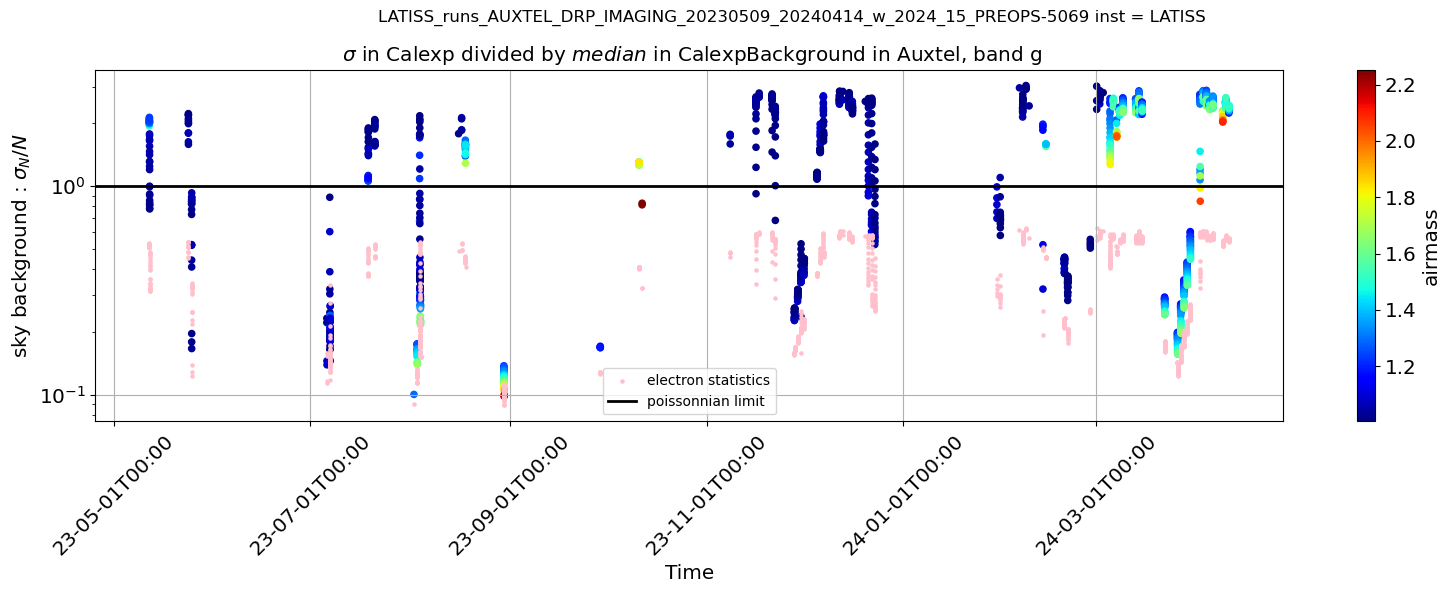

In [26]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band g"
df_g.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_g.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="pink",rot=45,label="electron statistics",grid=True)

ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandG_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in r band

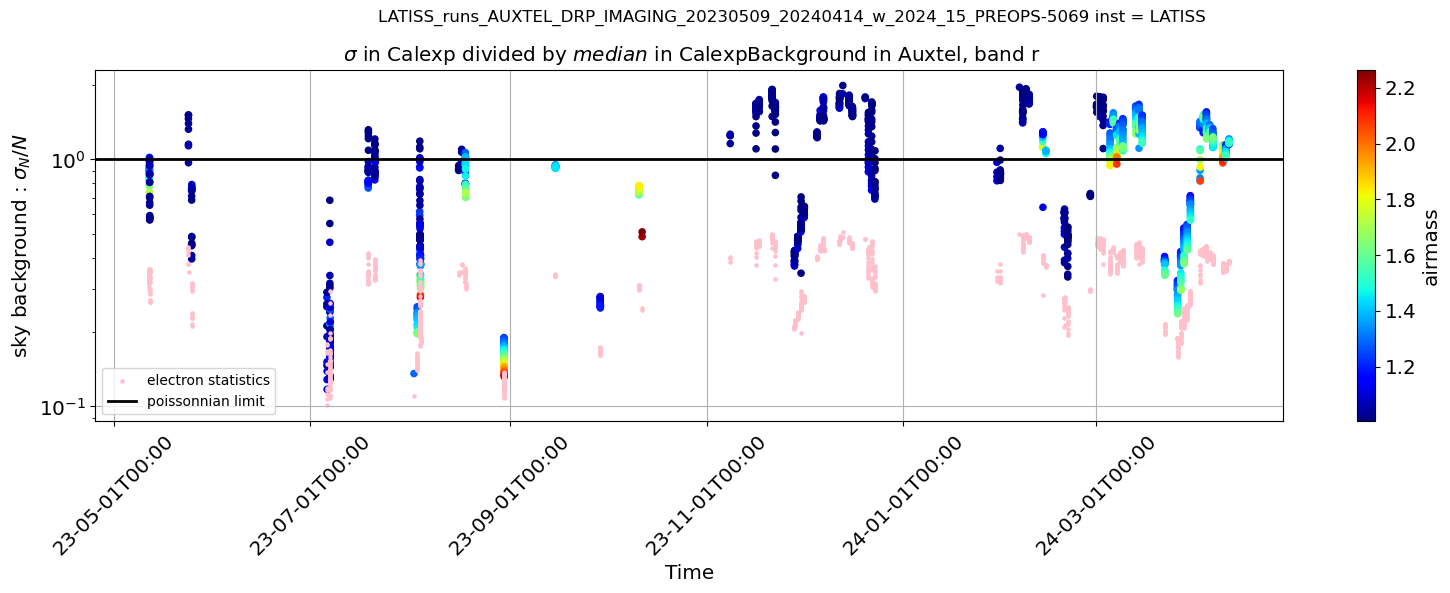

In [27]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band r"
df_r.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_r.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="pink",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandR_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in i band

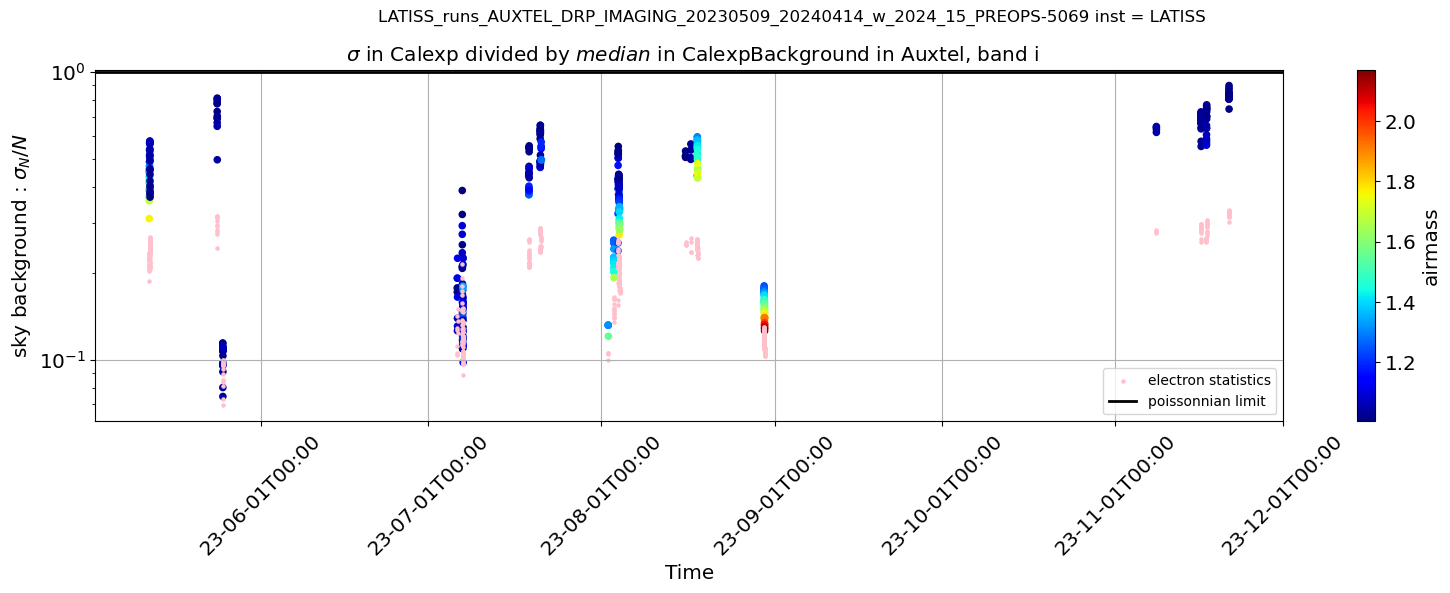

In [28]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band i"
df_i.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_i.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="pink",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
plt.suptitle(suptitle)
ax.set_ylabel("sky background : $\sigma_N/N$")
figname = "calexp_sigmaNbyN_bandI_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in z band

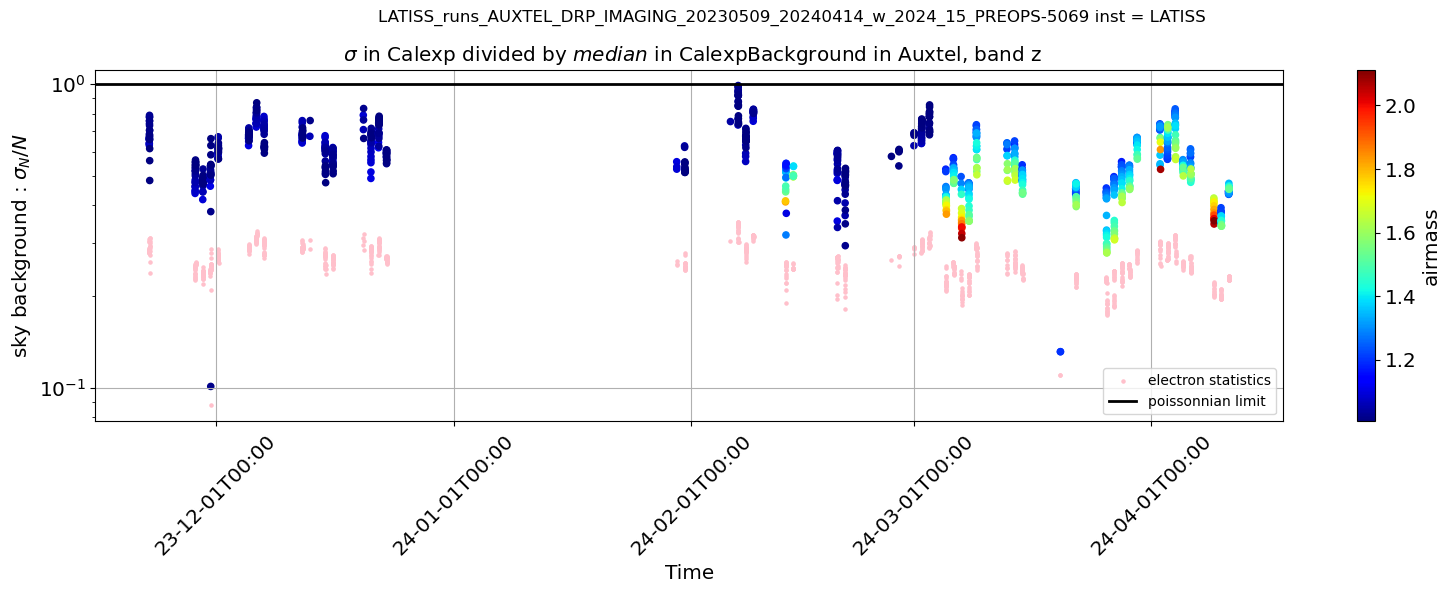

In [29]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band z"
df_z.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_z.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="pink",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandZ_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in y band

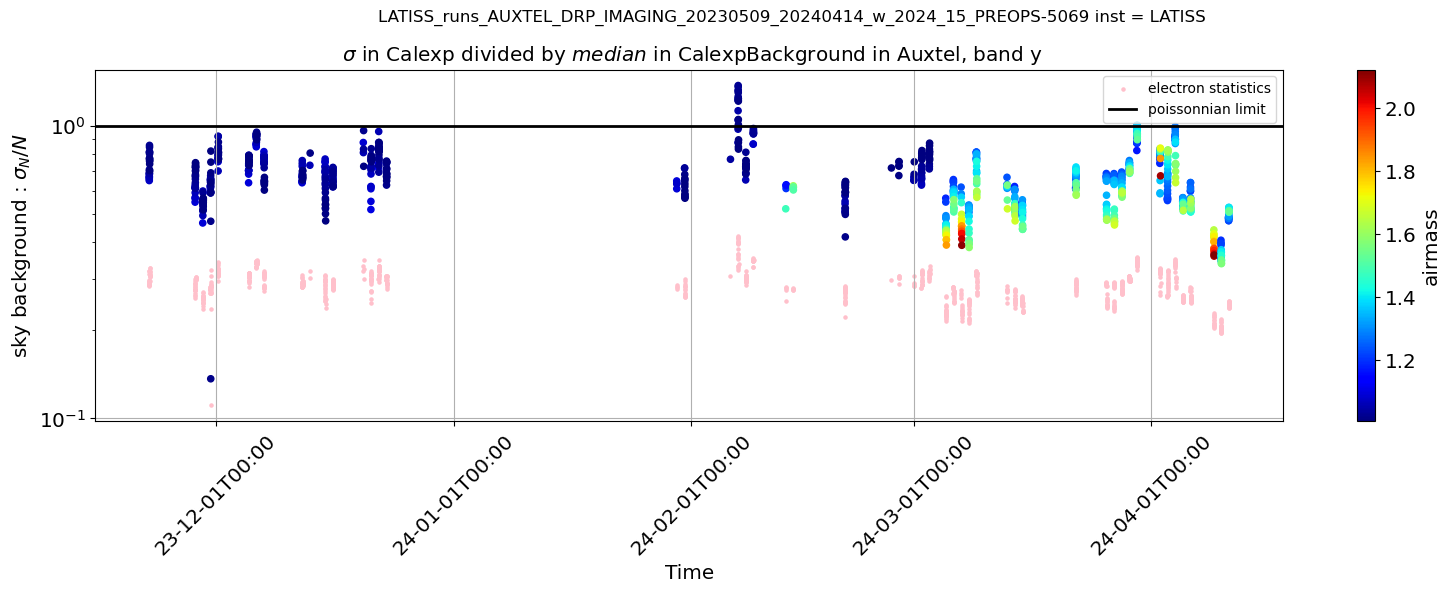

In [30]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band y"
df_y.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_y.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="pink",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandY_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()